<a href="https://colab.research.google.com/github/rahafbader/T5/blob/main/Time_Series_Forecasting_Practical_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 53.0MB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import timeseries_dataset_from_array
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error



In [3]:
df=pd.read_csv('/content/traffic-dataset.zip',parse_dates=['date_time'])
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       19980 non-null  float64       
 1   temp                 20000 non-null  float64       
 2   rain_1h              20000 non-null  float64       
 3   snow_1h              20000 non-null  float64       
 4   clouds_all           20000 non-null  int64         
 5   weather_main         20000 non-null  object        
 6   weather_description  20000 non-null  object        
 7   date_time            20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [4]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [5]:
df.index


RangeIndex(start=0, stop=20000, step=1)

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

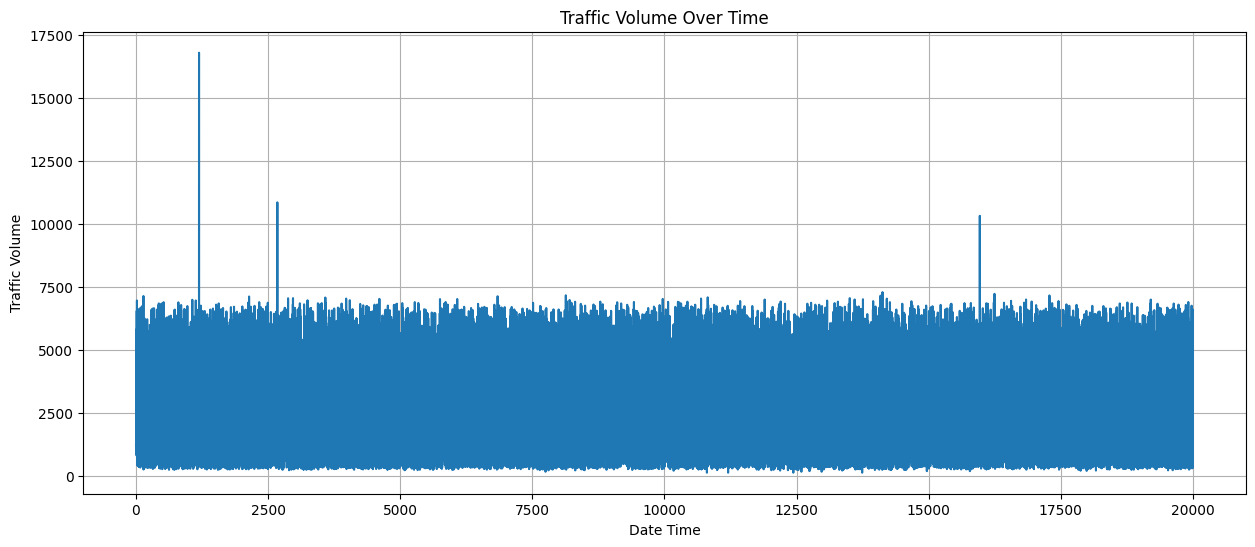

In [6]:
plt.figure(figsize=(15, 6))
plt.plot(df['traffic_volume'])
plt.title('Traffic Volume Over Time')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.show()


## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [7]:
df.isna().sum()
df['traffic_volume'].fillna(df['traffic_volume'].mean(),inplace=True)


In [8]:
print(df.isna().sum())

traffic_volume         0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
dtype: int64


In [9]:
df.duplicated().sum()


12

In [10]:
df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_main', 'weather_description', 'date_time'],
      dtype='object')

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [11]:
df['prev_traffic_volume'] = df['traffic_volume'].shift(1)

df['traffic_volume_diff'] = df['traffic_volume'].diff()


df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,prev_traffic_volume,traffic_volume_diff
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00,NaN,NaN
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00,1209.0,39.0
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00,1248.0,3354.0
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00,4602.0,-1764.0
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00,2838.0,2956.0


In [12]:
df['prev_traffic_volume'].fillna('0',inplace=True)
df['traffic_volume_diff'].fillna('0',inplace=True)



<ipython-input-12-68250bd0b63b>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['prev_traffic_volume'].fillna('0',inplace=True)
<ipython-input-12-68250bd0b63b>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['traffic_volume_diff'].fillna('0',inplace=True)


In [13]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,prev_traffic_volume,traffic_volume_diff
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00,0,0
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00,1209.0,39.0
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00,1248.0,3354.0
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00,4602.0,-1764.0
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00,2838.0,2956.0


In [14]:
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['day_of_year'] = df['date_time'].dt.dayofyear
df.head()


,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,prev_traffic_volume,traffic_volume_diff,day_of_week,month,day_of_year
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00,0,0,6,8,239
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00,1209.0,39.0,3,9,249
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00,1248.0,3354.0,4,8,237
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00,4602.0,-1764.0,3,11,313
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00,2838.0,2956.0,3,11,313


In [16]:
df.set_index('date_time', inplace=True)
df.sort_index(inplace=True)


In [15]:
df.head(40)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,prev_traffic_volume,traffic_volume_diff,day_of_week,month,day_of_year
0,1209.0,291.15,0.00,0.0,90,Mist,mist,2017-08-27 01:00:00,0,0,6,8,239
1,1248.0,286.01,0.00,0.0,1,Clear,sky is clear,2018-09-06 23:00:00,1209.0,39.0,3,9,249
2,4602.0,293.69,0.00,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00,1248.0,3354.0,4,8,237
3,2838.0,262.35,0.00,0.0,1,Clear,sky is clear,2017-11-09 22:00:00,4602.0,-1764.0,3,11,313
4,5794.0,267.08,0.00,0.0,5,Clear,sky is clear,2017-11-09 15:00:00,2838.0,2956.0,3,11,313
5,4257.0,293.66,0.00,0.0,75,Rain,moderate rain,2018-06-09 12:00:00,5794.0,-1537.0,5,6,160
6,3707.0,292.75,0.00,0.0,40,Rain,proximity shower rain,2018-07-26 19:00:00,4257.0,-550.0,3,7,207
7,5646.0,299.55,0.00,0.0,1,Thunderstorm,proximity thunderstorm,2018-08-03 15:00:00,3707.0,1939.0,4,8,215
8,2642.0,275.29,0.00,0.0,90,Fog,fog,2018-01-10 20:00:00,5646.0,-3004.0,2,1,10
9,801.0,296.43,0.00,0.0,1,Clear,sky is clear,2018-08-09 00:00:00,2642.0,-1841.0,3,8,221


## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [17]:
df_var= df[['traffic_volume', 'weather_main']]
train_data, test_data = train_test_split(df_var, test_size=0.3, shuffle=False)
val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)


In [18]:
train_data

,traffic_volume,weather_main
date_time,,
2016-11-18 15:00:00,4872.0,Snow
2016-11-18 15:00:00,4872.0,Fog
2016-11-18 15:00:00,4872.0,Mist
2016-11-18 16:00:00,5074.0,Fog
2016-11-18 16:00:00,5074.0,Mist
...,...,...
2018-03-09 14:00:00,5763.0,Clear
2018-03-09 15:00:00,6001.0,Clear
2018-03-09 16:00:00,6641.0,Clear


## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [19]:
train_data = pd.get_dummies(train_data, columns=['weather_main'], drop_first=True)
val_data = pd.get_dummies(val_data, columns=['weather_main'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['weather_main'], drop_first=True)

val_data = val_data.reindex(columns=train_data.columns, fill_value=0)
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)

scaler = MinMaxScaler()
train_data['traffic_volume'] = scaler.fit_transform(train_data[['traffic_volume']])
val_data['traffic_volume'] = scaler.transform(val_data[['traffic_volume']])
test_data['traffic_volume'] = scaler.transform(test_data[['traffic_volume']])

In [21]:
train_data.shape,val_data.shape,test_data.shape

((14000, 10), (3000, 10), (3000, 10))

In [22]:

window_size = 24
train_data = train_data.astype(float)
val_data = val_data.astype(float)
test_data = test_data.astype(float)

train_targets = train_data.iloc[window_size:, 0].values
val_targets = val_data.iloc[window_size:, 0].values
test_targets = test_data.iloc[window_size:, 0].values

train_Xy = timeseries_dataset_from_array(train_data.values, targets=train_targets, sequence_length=window_size, batch_size=32)
val_Xy = timeseries_dataset_from_array(val_data.values, targets=val_targets, sequence_length=window_size, batch_size=32)
test_Xy = timeseries_dataset_from_array(test_data.values, targets=test_targets, sequence_length=window_size, batch_size=32)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [23]:
RNN_model = Sequential()
RNN_model.add(SimpleRNN(units=50, return_sequences=True))
RNN_model.add(Dropout(0.1))
RNN_model.add(SimpleRNN(units=30))
RNN_model.add(Dense(units=1))
RNN_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [24]:
RNN_history = RNN_model.fit(train_Xy, epochs=10, validation_data=val_Xy)

Epoch 1/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0661 - mae: 0.1770 - val_loss: 0.0065 - val_mae: 0.0592
Epoch 2/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0069 - mae: 0.0649 - val_loss: 0.0034 - val_mae: 0.0434
Epoch 3/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0043 - mae: 0.0513 - val_loss: 0.0025 - val_mae: 0.0359
Epoch 4/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0033 - mae: 0.0446 - val_loss: 0.0020 - val_mae: 0.0329
Epoch 5/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0028 - mae: 0.0406 - val_loss: 0.0018 - val_mae: 0.0316
Epoch 6/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0024 - mae: 0.0372 - val_loss: 0.0016 - val_mae: 0.0292
Epoch 7/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0022 - mae: 0.0357 - val_loss: 0.0015 - val_mae: 0.0265
Epoch 8/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0020 - mae: 0.0340 - val_loss: 0.0014 - val_mae: 0.0249
Epoch 9/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 10s 2

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [25]:
y_test_pred = RNN_model.predict(test_Xy)
y_test_pred = y_test_pred.flatten()
print(y_test_pred[:10])

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
[0.36351237 0.33429953 0.26211226 0.22941184 0.2150437  0.19036406
 0.16476446 0.15636554 0.17689839 0.08780873]


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

Mean Absolute Error 0.022483394723036187


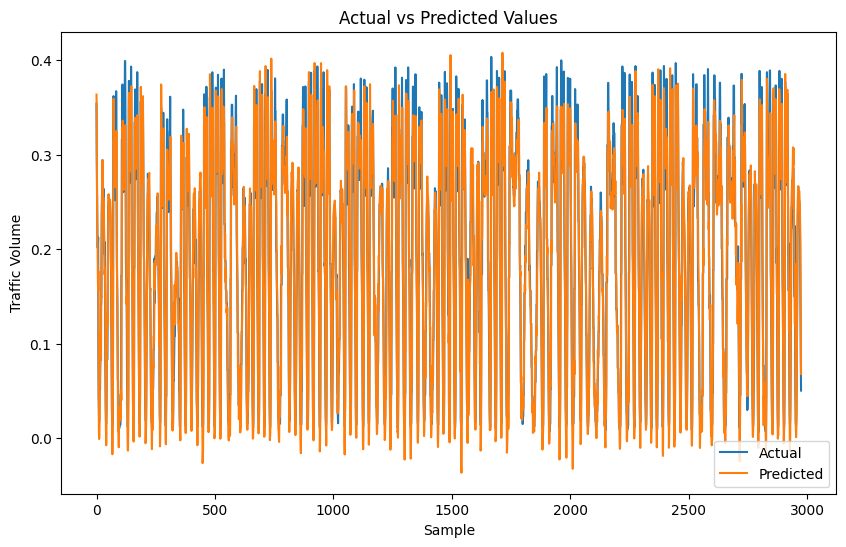

In [26]:
mae = mean_absolute_error(test_targets[:len(y_test_pred)], y_test_pred)

print(f'Mean Absolute Error {mae}')

plt.figure(figsize=(10, 6))
plt.plot(test_targets[:len(y_test_pred)], label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()


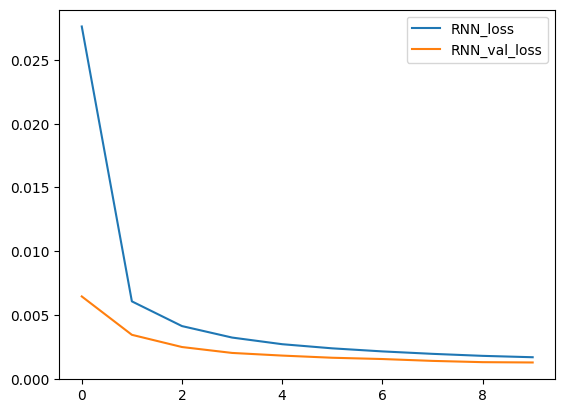

In [27]:
plt.plot(RNN_history.history['loss'],label='RNN_loss')
plt.plot(RNN_history.history['val_loss'],label='RNN_val_loss')
plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [28]:
GRU_model = Sequential()
GRU_model.add(GRU(units=50))

GRU_model.add(Dense(units=1))

GRU_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

GRU_model_hist = GRU_model.fit(train_Xy, epochs=10, validation_data=val_Xy)

Epoch 1/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0088 - mae: 0.0717 - val_loss: 0.0026 - val_mae: 0.0372
Epoch 2/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0021 - mae: 0.0340 - val_loss: 0.0020 - val_mae: 0.0308
Epoch 3/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0017 - mae: 0.0288 - val_loss: 0.0018 - val_mae: 0.0280
Epoch 4/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0015 - mae: 0.0267 - val_loss: 0.0017 - val_mae: 0.0273
Epoch 5/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0014 - mae: 0.0259 - val_loss: 0.0017 - val_mae: 0.0281
Epoch 6/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0014 - mae: 0.0254 - val_loss: 0.0017 - val_mae: 0.0281
Epoch 7/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0013 - mae: 0.0245 - val_loss: 0.0014 - val_mae: 0.0250
Epoch 8/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0012 - mae: 0.0235 - val_loss: 0.0013 - val_mae: 0.0235
Epoch 9/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 1

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [29]:
GRU_model = GRU_model.predict(test_Xy)
GRU_model = GRU_model.flatten()
print(y_test_pred[:10])

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[0.36351237 0.33429953 0.26211226 0.22941184 0.2150437  0.19036406
 0.16476446 0.15636554 0.17689839 0.08780873]


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

Mean Absolute Error 0.022483394723036187


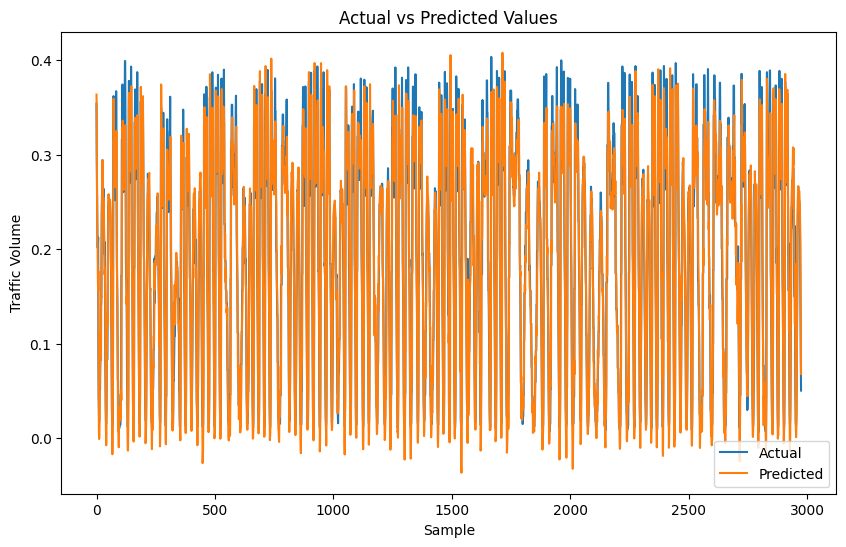

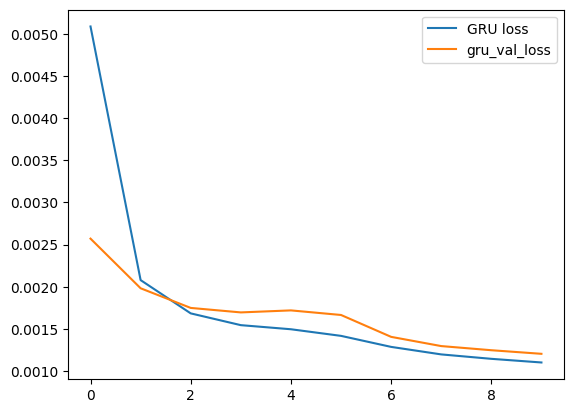

In [30]:
mae = mean_absolute_error(test_targets[:len(y_test_pred)], y_test_pred)

print(f'Mean Absolute Error {mae}')

plt.figure(figsize=(10, 6))
plt.plot(test_targets[:len(y_test_pred)], label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

plt.plot(GRU_model_hist.history['loss'],label='GRU loss')
plt.plot(GRU_model_hist.history['val_loss'],label='gru_val_loss')
plt.legend()
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

Data Preprocessing: first i chek for null and found 20 and fill it with mean,after that i do the normlization and encode which neccsary for train RNN model

Feature Engineering:as they ask foor new coulmn i create but i use the old to predict


Model Architecture:i use in model 1 simple RNN for simple i start with random number of layer and dropout
for model 2 i use GRU for its powrful and also i start with random number of layer and dropout until i got the good resulte


Training Process: i try many of batch size and epoch i choose the simple for sae the time and best resulte

Loss Function and Metrics: i choose mae becuse give me without squer so i can understand well

Model Tuning (If Done):

Overfitting and Underfitting: i deel with them by use good Architecture

Future Improvements:
